<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#libraries-and-widgets" data-toc-modified-id="libraries-and-widgets-0.0.0.1"><span class="toc-item-num">0.0.0.1&nbsp;&nbsp;</span>libraries and widgets</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Neuromatch-Academy-Project---Steinmetz-Dataset---Mouse-Mind-Reading" data-toc-modified-id="Neuromatch-Academy-Project---Steinmetz-Dataset---Mouse-Mind-Reading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neuromatch Academy Project - Steinmetz Dataset - Mouse Mind Reading</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#explore-dictionary-for-session" data-toc-modified-id="explore-dictionary-for-session-1.0.0.1"><span class="toc-item-num">1.0.0.1&nbsp;&nbsp;</span>explore dictionary for session</a></span></li></ul></li></ul></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#via-google-drive-directly" data-toc-modified-id="via-google-drive-directly-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>via google drive directly</a></span></li><li><span><a href="#cleanup-channel-infos" data-toc-modified-id="cleanup-channel-infos-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>cleanup channel infos</a></span></li><li><span><a href="#cleaning-up-spikes" data-toc-modified-id="cleaning-up-spikes-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>cleaning up spikes</a></span></li><li><span><a href="#cleanup-trial-info" data-toc-modified-id="cleanup-trial-info-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>cleanup trial info</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.pyplot as plt
import qgrid

from nma_class import NMA_project

%matplotlib inline

#### libraries and widgets
- qgrid
- nbextentions

In [2]:
# only if you are on jupyter notebook not if on colab
import qgrid

In [3]:
# only if you are on google coalb not if you are on jupyter notebook
#from google.colab import drive
#drive.mount('/content/gdrive')

# Neuromatch Academy Project - Steinmetz Dataset - Mouse Mind Reading

In [8]:
# link to parent folder with all datasets
#main_folder = "/content/gdrive/My Drive/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
#main_folder = "C:/Users/User/Google Drive/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
#main_folder = "Z:/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
main_folder = os.path.join('//Volumes','Samsung_T5','steinmetz_dataset')

# create session object
nma_obj = NMA_project(main_folder) 

# default session is initialized, extract interesting dataframes in dedicated variables
session = nma_obj.std_session
channels_df = session['channels_df']
spikes_df = session['spikes_df']
clusters_df = session['clusters_df']
trials_df = session['trials_df']


#### explore dictionary for session
- each ession is a dictionary
- each element kontains eather a numpy array or a dataframe
- the most important dataframes we are going to work with are:
    - clusters_df: all the spikes and clusters
    - trials_df: all the behaviour data for all trials

In [9]:
for key, value in nma_obj.std_session.items():
    print(key, value.shape)

face_timestamps (2, 2)
trials_feedback_times (214, 1)
passiveVisual_times (150, 1)
clusters_templateWaveformChans (1085, 50)
passiveVisual_contrastLeft (150, 1)
passiveVisual_contrastRight (150, 1)
passiveBeeps_times (25, 1)
trials_included (214, 1)
wheelMoves_intervals (507, 2)
channels_rawRow (748, 1)
clusters_peakChannel (1085, 1)
channels_brainLocation (748, 4)
licks_times (3190, 1)
Cori_2016-12-14_M2_g0_t0_imec_lf_timestamps (2, 2)
trials_visualStim_times (214, 1)
probes_sitePositions (384, 2)
clusters_waveformDuration (1085, 1)
passiveWhiteNoise_times (25, 1)
passiveValveClick_times (25, 1)
channels_sitePositions (748, 2)
eye_area (267759, 1)
trials_visualStim_contrastRight (214, 1)
clusters_originalIDs (1085, 1)
lickPiezo_timestamps (2, 2)
clusters_probes (1085, 1)
wheel_timestamps (2, 2)
trials_intervals (214, 2)
clusters_depths (1085, 1)
trials_response_times (214, 1)
sparseNoise_positions (7962, 2)
Cori_2016-12-14_V1_g0_t0_imec_lf_timestamps (2, 2)
probes_description (2, 1)
s

In [10]:
qgrid.show_grid(channels_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [11]:
qgrid.show_grid(clusters_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [12]:
qgrid.show_grid(trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Load Data


### via google drive directly

In [ ]:
def load_session(folder):
    """
    load all files from given folder to dict
    return dict with key as filenames
    """
    # load session files ===========================================
    from os import listdir
    from os.path import isfile, join
    files = [f for f in listdir(folder) if isfile(join(folder, f))]
    names = ['_'.join(f.split('.')[:-1]) for f in files]
    session = dict()
    for (file_, name_) in zip(files, names):
        if file_.split('.')[-1] == 'npy':
        session[name_] = np.load(folder+'/'+file_)
        if file_.split('.')[-1] == 'tsv':
        session[name_] = pd.read_table(folder+'/'+file_)

    # pars session info two dataframe ===============================
    # create spike_df tataframe, with each spike time and the cluster it belongs to
    spikes_df = pd.DataFrame( { 'cluster':session['spikes_clusters'][:,0], 'spike_times': session['spikes_times'][:,0] }, ) 

    # create cluster dataframe information and spikes for each cluster
    clusters = np.unique(session['spikes_clusters'])
    # create number of spikes, phy2 manual cluster, 
    # parse phy annotation
    clusters_df = pd.DataFrame({'lable':session['clusters__phy_annotation'][:,0], 'probe':session['clusters_probes'][:,0], 'peak channel':session['clusters_peakChannel'][:,0]}, index=clusters )
    # pars labels in strings 1 = good 3 = mua
    #clusters_df['lable'] = clusters_df['lable'].apply( lambda lable: 'good' if lable==3 else ('mua' if lable==1 else 'bad') )

    # create spikes colum with spiketimes
    spk = pd.DataFrame( {'spikes':np.zeros(len(clusters), dtype=object)}, index=clusters )
    for group, frame in spikes_df.groupby('cluster'):
        spk['spikes'][group] = frame['spike_times'].values

    #merge spike column with clusters_df
    clusters_df = pd.merge(clusters_df, spk, how='right', left_index=True, right_index=True)
    # set index name
    clusters_df.index.name='cluster'
    # number of spikes per cluster
    clusters_df['total spikes'] = clusters_df['spikes'].apply(lambda row: len(row) )

# def load_session(folder, sessions):
#   """
#   load all files in each given session and add to session dict
#   returs a dict of sessions, with each session a dict of files
#   """
#   sessions_data = dict()
#   for session in sessions:
#     current_session = dict()
#     sessions[session] = 

In [ ]:
# example google colab load session
#folder = "/content/gdrive/My Drive/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
#folder = "C:/Users/User/Google Drive/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
folder = "Z:/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"

subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
sessions = [folder.split('/')[-1] for folder in subfolders]

# load first session
session = load_session(subfolders[0])

In [ ]:
folder = "Z:/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset/Cori_2016-12-14"
session = load_session(folder)

In [ ]:
for key in session.keys():
  print(key)

### cleanup channel infos

In [ ]:
# load channel brain location infos
brain = pd.DataFrame(session['channels_brainLocation'])
# load channel probes
site = pd.DataFrame(session['channels_sitePositions'], columns=['channel 0', 'channel 1'])
# merge with channles_df
channels_df = pd.merge(brain, site, how='inner', left_index=True, right_index=True)
# load probe, row and site
meta = pd.DataFrame({'probe':session['channels_probe'][:,0],
                            'raw row':session['channels_rawRow'][:,0],
                            'channels_site':session['channels_site'][:,0] })
# merge metha with channel_df
channels_df = pd.merge(channels_df, meta, how='inner', left_index=True, right_index=True)

In [ ]:
qgrid.show_grid(channels_df)

### cleaning up spikes

In [ ]:
# create spike_df tataframe, with each spike time and the cluster it belongs to
spikes_df = pd.DataFrame( { 'cluster':session['spikes_clusters'][:,0], 'spike_times': session['spikes_times'][:,0] }, ) 
qgrid.show_grid(spikes_df)

In [ ]:
# create cluster dataframe information and spikes for each cluster
clusters = np.unique(session['spikes_clusters'])
# create number of spikes, phy2 manual cluster, 
# parse phy annotation
clusters_df = pd.DataFrame({'lable':session['clusters__phy_annotation'][:,0], 'probe':session['clusters_probes'][:,0], 'peak channel':session['clusters_peakChannel'][:,0]}, index=clusters )
# pars labels in strings 1 = good 3 = mua
#clusters_df['lable'] = clusters_df['lable'].apply( lambda lable: 'good' if lable==3 else ('mua' if lable==1 else 'bad') )



# create spikes colum with spiketimes
spk = pd.DataFrame( {'spikes':np.zeros(len(clusters), dtype=object)}, index=clusters )
for group, frame in spikes_df.groupby('cluster'):
    spk['spikes'][group] = frame['spike_times'].values

#merge spike column with clusters_df
clusters_df = pd.merge(clusters_df, spk, how='right', left_index=True, right_index=True)
# set index name
clusters_df.index.name='cluster'
# number of spikes per cluster
clusters_df['total spikes'] = clusters_df['spikes'].apply(lambda row: len(row) )

In [ ]:
qgrid.show_grid(clusters_df)

### cleanup trial info

In [14]:
print(session['trials_feedbackType'].shape)
print(session['trials_feedback_times'].shape)
print(session['trials_goCue_times'].shape)
print(session['trials_included'].shape)
print(session['trials_intervals'].shape)
print(session['trials_repNum'].shape)
print(session['trials_response_choice'].shape)
print(session['trials_response_times'].shape)
print(session['trials_visualStim_contrastLeft'].shape)
print(session['trials_visualStim_contrastRight'].shape)
print(session['trials_visualStim_times'].shape)

(214, 1)
(214, 1)
(214, 1)
(214, 1)
(214, 2)
(214, 1)
(214, 1)
(214, 1)
(214, 1)
(214, 1)
(214, 1)


In [15]:
# create trials dataframe
trials_df = pd.DataFrame({'included':session['trials_included'][:,0],
                          'repetition number':session['trials_repNum'][:,0],
                          # times of events
                          'go cue':session['trials_goCue_times'][:,0],
                          'stim time':session['trials_visualStim_times'][:,0],
                          'response time':session['trials_response_times'][:,0],
                          'feedback time':session['trials_feedback_times'][:,0],
                          
                          #'intervals':session['trials_intervals'][:,0], # same as go cue
                          
                          
                          'go cue':session['trials_intervals'][:,0],
                          
                          'stim contrast left':session['trials_visualStim_contrastLeft'][:,0],
                          'stim contrast right':session['trials_visualStim_contrastRight'][:,0],
                          
                          'response choice':session['trials_response_choice'][:,0],
                          'response time':session['trials_response_times'][:,0],
                          'feedback type':session['trials_feedbackType'][:,0],
                          
                         })

In [29]:
trials_df

,included,repetition number,go cue,stim time,response time,feedback time,stim contrast left,stim contrast right,response choice,feedback type
0,True,1.0,62.900284,65.269408,66.419612,66.456227,1.00,0.0,1.0,1.0
1,True,1.0,68.420838,71.202703,72.602206,72.640326,0.00,0.5,-1.0,1.0
2,True,1.0,74.602902,76.052380,77.001671,77.038396,1.00,0.5,1.0,1.0
3,True,1.0,79.003653,81.235263,83.502065,83.531699,0.00,0.0,0.0,1.0
4,True,1.0,85.501795,86.800952,87.617727,87.628565,0.50,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
209,False,5.0,1109.529226,1110.110867,1111.564004,1111.571290,0.25,1.0,1.0,-1.0
210,False,6.0,1113.562081,1114.277333,1115.497692,1115.508153,0.25,1.0,1.0,-1.0
211,False,7.0,1117.495128,1117.926592,1120.232805,1120.237428,0.25,1.0,0.0,-1.0
212,False,8.0,1122.231454,1122.576266,1124.854126,1124.857902,0.25,1.0,0.0,-1.0


In [16]:
qgrid.show_grid(trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [17]:
# add wheelmovement
print(session['wheel_position'].shape)
print(session['wheel_timestamps'].shape)
print(session['wheelMoves_intervals'].shape)
print(session['wheelMoves_type'].shape)

(6570000, 1)
(2, 2)
(507, 2)
(507, 1)


In [19]:
wheel_df = pd.merge( pd.DataFrame(session['wheelMoves_intervals']), pd.DataFrame(session['wheelMoves_type']), how='left', left_index=True, right_index=True)

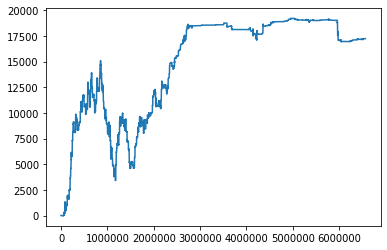

In [23]:
plt.figure
wheelpos = session['wheel_position']
plt.plot(wheelpos)

In [ ]:
qgrid.show_grid(pd.DataFrame(wheel_df))